In [1]:
# --- Env & Imports ---
from pathlib import Path
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 보기 편한 옵션
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 160)

# --- CSV 탐색: notebooks/ 위치 상관없이 artifacts/aggregated.csv 탐색 ---
def find_file_upwards(rel_path: str, max_hops: int = 5):
    cur = Path.cwd()
    target = Path(rel_path)
    for _ in range(max_hops + 1):
        cand = cur / target
        if cand.exists():
            return cand
        if cur.parent == cur:
            break
        cur = cur.parent
    return None

csv_path = find_file_upwards("artifacts/aggregated.csv")
if not csv_path:
    raise FileNotFoundError("artifacts/aggregated.csv를 상위 디렉토리로 거슬러 올라가며 찾지 못했습니다.")

print("FOUND:", csv_path.resolve())

# --- Load ---
df = pd.read_csv(csv_path)
print("shape:", df.shape)
df.head()

FOUND: /Users/junghoshin/Documents/swing-analyzer/artifacts/aggregated.csv
shape: (21, 62)


,swingId,input.filePath,input.side,input.club,env,appVersion,timestamp,preprocess.mode,preprocess.ms,preprocess.fps,preprocess.height,preprocess.mirror,pose.frameStep,pose.minVisibility,rules.club,rules.fingerprint,rules.keyCount,phase.method,detectedFrames,totalFrames,detectionRate,metrics.elbow_avg,metrics.knee_avg,file,phase_idx.P2,phase_idx.P3,phase_idx.P4,phase_idx.P5,phase_idx.P6,phase_idx.P7,phase_idx.P8,phase_idx.P9,phase.P2.elbow,phase.P2.knee,phase.P2.spine_tilt,phase.P3.elbow,phase.P3.knee,phase.P3.spine_tilt,phase.P4.elbow,phase.P4.knee,phase.P4.spine_tilt,phase.P5.elbow,phase.P5.knee,phase.P5.spine_tilt,phase.P6.elbow,phase.P6.knee,phase.P6.spine_tilt,phase.P7.elbow,phase.P7.knee,phase.P7.spine_tilt,phase.P8.elbow,phase.P8.knee,phase.P8.spine_tilt,phase.P9.elbow,phase.P9.knee,phase.P9.spine_tilt,diag.AVG.elbow_diag,diag.AVG.knee_diag,diag.P4.elbow_diag,diag.P4.spine_tilt_diag,diag.P7.elbow_diag,diag.P7.knee_diag
0,029c6fea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80,80,1.0,110.9,128.4,029c6fea_47528c.json,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,075e4651,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80,80,1.0,110.9,128.4,075e4651_461251.json,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,197814af,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67,67,1.0,133.8,130.8,197814af_0d464f.json,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,336f151c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67,67,1.0,133.8,130.8,336f151c_67e8cd.json,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3cdc321e,uploads/3cdc321e_아이언 스윙 test.mp4,right,iron,test,unknown,1.759229e+09,pro,1031.0,30.0,720.0,False,3.0,0.5,iron,4fe7465060,6.0,auto,67,67,1.0,133.8,130.8,3cdc321e_cc74e8.json,0.0,8.0,16.0,24.0,32.0,40.0,48.0,56.0,130.9,112.1,6.0,131.5,109.3,4.3,108.4,77.1,0.5,177.3,108.4,1.4,161.8,109.0,3.3,151.6,149.7,12.7,153.6,165.1,8.2,167.3,166.0,6.1,팔꿈치 각도가 적정 범위입니다(아이언 기준).,무릎 굴곡이 큰 편입니다.,백스윙 톱(P4)에서 팔꿈치가 과도하게 굽혀졌습니다.,P4에서 척추 기울기가 거의 없어 상체가 들렸습니다.,임팩트(P7) 팔꿈치 각도가 적정 범위입니다.,임팩트(P7) 무릎 각도가 적정 범위입니다.


In [2]:
print("columns (first 30):", df.columns.tolist()[:30])

# 핵심 분포
print(df[["input.club", "env", "phase.method"]].value_counts(dropna=False))

# 평균 메트릭 요약
print(df[["metrics.elbow_avg","metrics.knee_avg"]].describe())

# 주요 phase 인덱스 요약
cols = [c for c in ["phase_idx.P2","phase_idx.P3","phase_idx.P4","phase_idx.P5","phase_idx.P6","phase_idx.P7","phase_idx.P8","phase_idx.P9"] if c in df.columns]
print(df[cols].describe())

columns (first 30): ['swingId', 'input.filePath', 'input.side', 'input.club', 'env', 'appVersion', 'timestamp', 'preprocess.mode', 'preprocess.ms', 'preprocess.fps', 'preprocess.height', 'preprocess.mirror', 'pose.frameStep', 'pose.minVisibility', 'rules.club', 'rules.fingerprint', 'rules.keyCount', 'phase.method', 'detectedFrames', 'totalFrames', 'detectionRate', 'metrics.elbow_avg', 'metrics.knee_avg', 'file', 'phase_idx.P2', 'phase_idx.P3', 'phase_idx.P4', 'phase_idx.P5', 'phase_idx.P6', 'phase_idx.P7']
input.club  env   phase.method
NaN         NaN   NaN             20
iron        test  auto             1
Name: count, dtype: int64
       metrics.elbow_avg  metrics.knee_avg
count          21.000000         21.000000
mean          119.623810        129.314286
std            11.395346          1.194272
min           110.900000        128.400000
25%           110.900000        128.400000
50%           110.900000        128.400000
75%           133.800000        130.800000
max          

In [3]:
# 레거시 호환 + 기본 치환
dnf = df.copy()

def _empty(x):
    return (x is None) or (x == "") or (isinstance(x, float) and np.isnan(x))

# 상위 키에서 하위 키로 백필
if "club" in dnf.columns and "input.club" in dnf.columns:
    dnf["input.club"] = dnf["input.club"].fillna(dnf["club"])
if "side" in dnf.columns and "input.side" in dnf.columns:
    dnf["input.side"] = dnf["input.side"].fillna(dnf["side"])

# 기본 치환
for col in ["input.club", "env", "phase.method"]:
    if col in dnf.columns:
        dnf[col] = dnf[col].apply(lambda v: "unknown" if _empty(v) else v)

dnf[["input.club","env","phase.method"]].value_counts(dropna=False)

input.club  env      phase.method
unknown     unknown  unknown         20
iron        test     auto             1
Name: count, dtype: int64

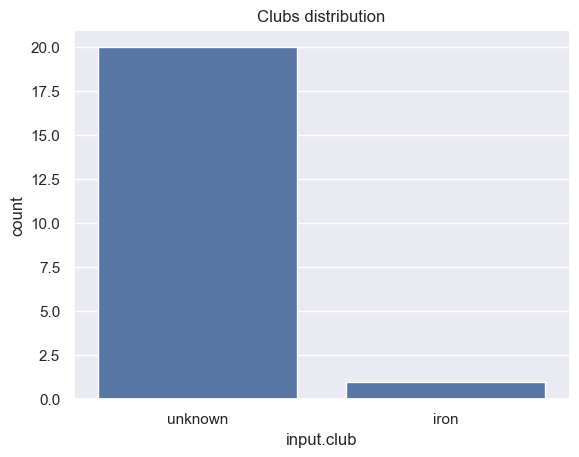

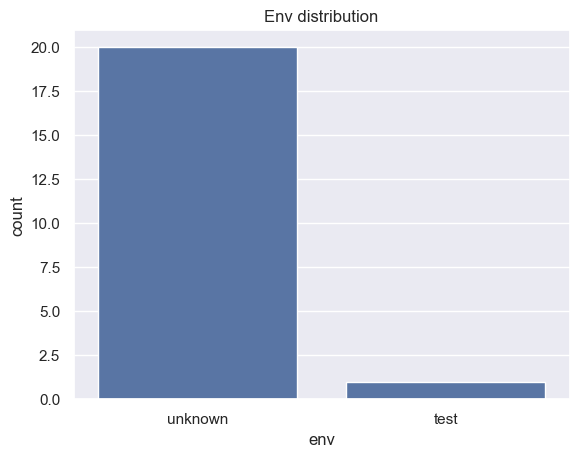

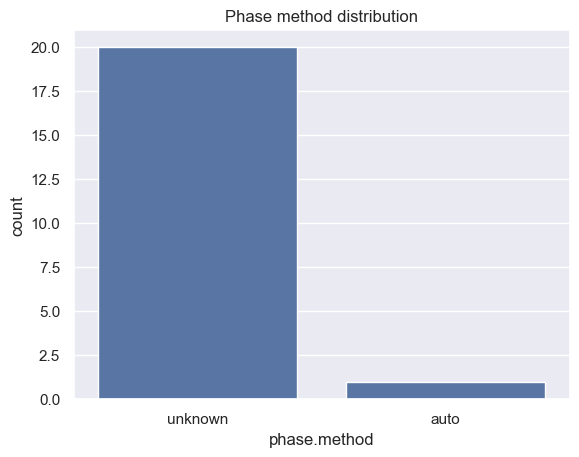

In [4]:
# 시각화 스타일
sns.set_theme()

# club 분포
sns.countplot(x="input.club", data=dnf)
plt.title("Clubs distribution")
plt.show()

# env 분포
sns.countplot(x="env", data=dnf)
plt.title("Env distribution")
plt.show()

# phase.method 분포
sns.countplot(x="phase.method", data=dnf)
plt.title("Phase method distribution")
plt.show()

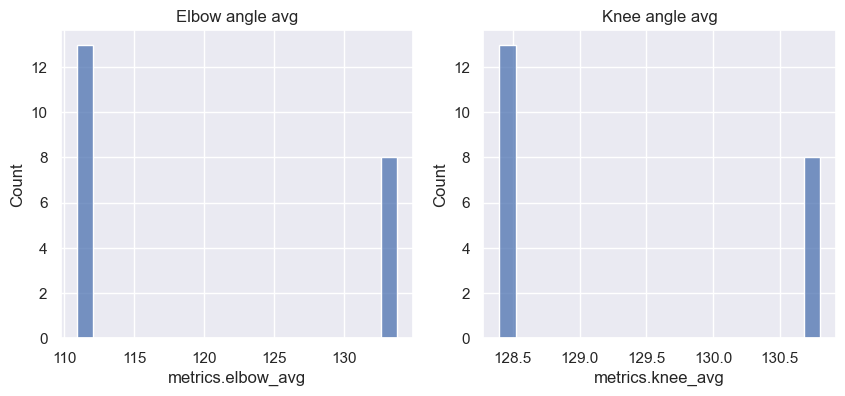

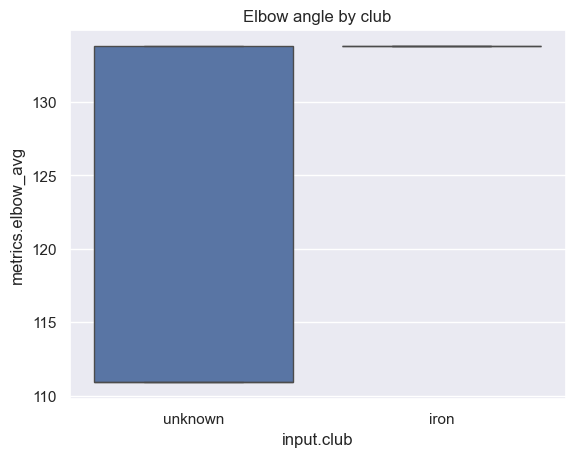

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
sns.histplot(dnf["metrics.elbow_avg"].dropna(), bins=20, ax=axes[0])
axes[0].set_title("Elbow angle avg")
sns.histplot(dnf["metrics.knee_avg"].dropna(), bins=20, ax=axes[1])
axes[1].set_title("Knee angle avg")
plt.show()

sns.boxplot(x="input.club", y="metrics.elbow_avg", data=dnf)
plt.title("Elbow angle by club")
plt.show()

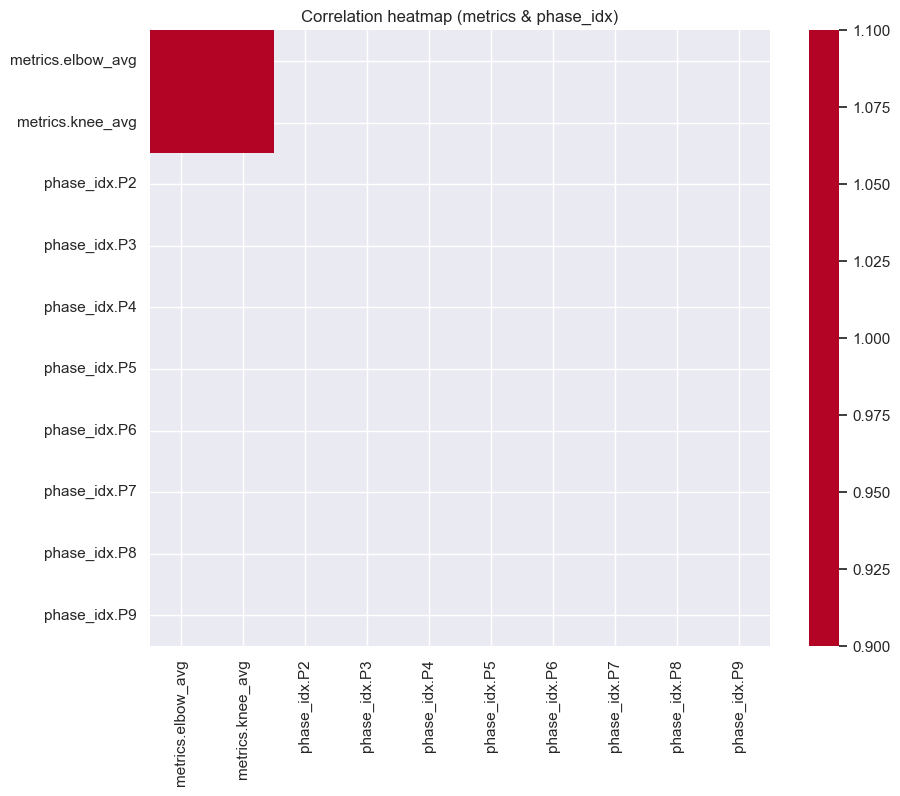

In [6]:
num_cols = [c for c in dnf.columns if c.startswith("metrics.") or c.startswith("phase_idx.")]
corr = dnf[num_cols].corr(numeric_only=True)
plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation heatmap (metrics & phase_idx)")
plt.show()

In [7]:
missing = dnf.isna().mean().sort_values(ascending=False).head(20)
print(missing)

preprocess.ms              0.952381
preprocess.fps             0.952381
rules.fingerprint          0.952381
rules.club                 0.952381
pose.minVisibility         0.952381
pose.frameStep             0.952381
preprocess.mirror          0.952381
preprocess.height          0.952381
rules.keyCount             0.952381
preprocess.mode            0.952381
timestamp                  0.952381
appVersion                 0.952381
input.filePath             0.952381
input.side                 0.952381
diag.P4.elbow_diag         0.857143
diag.AVG.knee_diag         0.857143
diag.P7.knee_diag          0.857143
diag.AVG.elbow_diag        0.857143
diag.P4.spine_tilt_diag    0.857143
diag.P7.elbow_diag         0.857143
dtype: float64


In [8]:
out_path = Path("../artifacts/eda_summary.json")
out_path.parent.mkdir(parents=True, exist_ok=True)

summary = {
    "row_count": int(len(dnf)),
    "by_club": dnf["input.club"].value_counts(dropna=False).to_dict() if "input.club" in dnf else {},
    "by_env": dnf["env"].value_counts(dropna=False).to_dict() if "env" in dnf else {},
    "by_phase_method": dnf["phase.method"].value_counts(dropna=False).to_dict() if "phase.method" in dnf else {},
    "metrics_elbow": dnf["metrics.elbow_avg"].describe().to_dict() if "metrics.elbow_avg" in dnf else {},
    "metrics_knee": dnf["metrics.knee_avg"].describe().to_dict() if "metrics.knee_avg" in dnf else {},
}
import json
out_path.write_text(json.dumps(summary, ensure_ascii=False, indent=2), encoding="utf-8")
print("saved:", out_path.resolve())
summary

saved: /Users/junghoshin/Documents/swing-analyzer/artifacts/eda_summary.json


{'row_count': 21,
 'by_club': {'unknown': 20, 'iron': 1},
 'by_env': {'unknown': 20, 'test': 1},
 'by_phase_method': {'unknown': 20, 'auto': 1},
 'metrics_elbow': {'count': 21.0,
  'mean': 119.62380952380957,
  'std': 11.395345749993936,
  'min': 110.9,
  '25%': 110.9,
  '50%': 110.9,
  '75%': 133.8,
  'max': 133.8},
 'metrics_knee': {'count': 21.0,
  'mean': 129.31428571428575,
  'std': 1.194272043667489,
  'min': 128.4,
  '25%': 128.4,
  '50%': 128.4,
  '75%': 130.8,
  'max': 130.8}}